## 추세 지표에 따른 투자
* 추세 : 주가가 진행하는 방향
* 모멘텀, 방향성지수, 엔빌롭 등등..

In [1]:
import os
import pandas as pd
from tqdm import tqdm

sp_data_dict = dict()
for file_name in tqdm(os.listdir("data/주가데이터")):
    sp_data = pd.read_csv("data/주가데이터/" + file_name, parse_dates = ['Date'])
    stock_name = file_name.replace('.csv', '')
    sp_data_dict[stock_name] = sp_data

100%|██████████| 2170/2170 [00:19<00:00, 111.19it/s]


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
sns.set()
%matplotlib inline
rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False

## 모멘텀
* 시장의 과매입 혹은 과매도 상태를 나타내는 지표. 일정 기간 동안의 주가 상승 및 하락을 알려주는 기초 추세 지표
* 모멘텀_n = (금일 종가 - n 영업일 전 종가) / n영업일 전 종가 * 100 (%)
* 모멘텀이 양ㅅ이면 현재 상승 추세에 있다고 판단하여 매수. 반대일때 매도


In [4]:
import numpy as np

mom_data = pd.DataFrame()
for stock_name in tqdm(sp_data_dict.keys()):
    sp_data = sp_data_dict[stock_name]
    sp = sp_data["Close"].values

    # 모멘텀 계산
    # 모멘텀은 단기 추세 지표이므로 5, 10, 20일 생성
    mom_5 = (sp[5:] - sp[:-5]) / sp[:-5] * 100
    mom_10 = (sp[10:] - sp[:-10]) / sp[:-10] * 100
    mom_20 = (sp[20:] - sp[:-20]) / sp[:-20] * 100
    mom_5 = np.insert(mom_5, [0] * 5, np.nan)
    mom_10 = np.insert(mom_10, [0] * 10, np.nan)
    mom_20 = np.insert(mom_20, [0] * 20, np.nan)

    # 모멘텀 변수 추가
    temp = pd.DataFrame({"Date":sp_data['Date'].values})
    temp["모멘텀_5"] = mom_5
    temp["모멘텀_10"] = mom_10
    temp["모멘텀_20"] = mom_20

    # 수익률 추가
    ror_5 = np.insert(mom_5, [-1] * 5, np.nan)[5:]
    ror_10 = np.insert(mom_10, [-1] * 10, np.nan)[10:]
    ror_20 = np.insert(mom_20, [-1] * 20, np.nan)[20:]
    temp["수익률_5"] = ror_5
    temp["수익률_10"] = ror_10
    temp["수익률_20"] = ror_20

    temp.dropna(inplace = True)
    mom_data = pd.concat([mom_data, temp], axis = 0, ignore_index = True)

100%|██████████| 2170/2170 [01:45<00:00, 20.66it/s]


In [5]:
# 리밸런싱

result = []
date_list = sorted(mom_data["Date"].unique())
for date in tqdm(date_list):
    temp = mom_data.loc[mom_data['Date'] == date]
    for n in [5, 10, 20]:
        # 모멘텀 정도에 따라 0 ~ 4까지의 그룹으로 분류. 그룹 0이 가장 낮은 모멘텀을 가지는 그룹
        temp["그룹"] = pd.qcut(temp['모멘텀_' + str(n)], 5,labels = range(5)).astype(int)

        for group in range(5):
            ror_list = temp.loc[temp["그룹"] == group, "수익률_" + str(n)].values
            inve_per_stock = 10 ** 8 / sum(temp["그룹"] == group)
            profit = (inve_per_stock * ror_list / 100).sum()
            profit_ratio = profit / 10 ** 8 * 100
            result.append([n, group, profit_ratio])

result = pd.DataFrame(result, columns = ["영업일", "그룹", "수익률"])

100%|██████████| 2608/2608 [01:17<00:00, 33.63it/s]


<AxesSubplot:xlabel='영업일,그룹'>

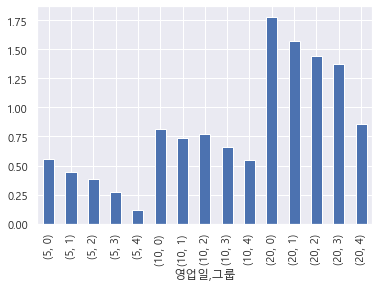

In [6]:
result.groupby(['영업일', '그룹'])['수익률'].mean().round(2).plot(kind = 'bar')

# 모멘텀이 가장 적은 0이 가장 높은 수익률을 보이고, 순서대로 낮아짐
# 모든 그룹에서 0 이상의 수익률을 보임!

<AxesSubplot:xlabel='영업일,그룹'>

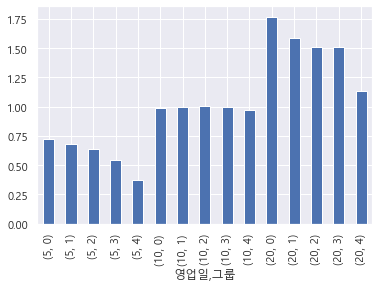

In [7]:
result.groupby(['영업일', '그룹'])['수익률'].median().round(2).plot(kind = 'bar')

# 10 영업일을 제외하고 중위수도 비슷한 형태를 보임
# 이는 인식과 다르게 모멘텀이 낮은 그룹에 투자하는것이 좋은것을 의미

In [8]:
print(result.groupby(['영업일', '그룹'])['수익률'].describe().round(2))

# 대부분의 지표에서 그룹 0이 가장 높음. 그러나 최소값과 1사분위수도 가장 낮음
# 이는 수익과 손실 모두 크다는 것을 의미함. 그럼에도 평균값이 가장 높기 때문에 그룹 0에 투자하는것이 더 좋음

         count  mean   std    min   25%   50%   75%    max
영업일 그룹                                                    
5   0   2608.0  0.56  3.73 -33.55 -1.20  0.72  2.43  36.06
    1   2608.0  0.44  3.21 -30.06 -0.95  0.68  2.00  29.11
    2   2608.0  0.38  2.91 -29.21 -0.90  0.64  1.86  24.51
    3   2608.0  0.27  2.74 -24.76 -0.90  0.54  1.75  19.94
    4   2608.0  0.12  2.83 -20.79 -1.28  0.37  1.84  14.10
10  0   2608.0  0.81  5.27 -42.37 -1.91  0.99  3.50  58.36
    1   2608.0  0.74  4.52 -41.07 -1.45  1.00  3.00  46.67
    2   2608.0  0.77  4.13 -37.58 -1.21  1.01  2.97  39.12
    3   2608.0  0.66  3.84 -32.61 -1.25  1.00  2.85  29.38
    4   2608.0  0.55  4.01 -27.55 -1.70  0.97  3.07  19.07
20  0   2608.0  1.78  7.37 -42.76 -2.28  1.77  5.73  78.75
    1   2608.0  1.57  6.42 -39.66 -1.72  1.59  5.06  65.12
    2   2608.0  1.44  5.84 -39.25 -1.48  1.51  4.55  52.55
    3   2608.0  1.37  5.45 -33.69 -1.47  1.51  4.46  43.98
    4   2608.0  0.86  5.85 -40.76 -2.68  1.13  4.52  23.

## 방향성 지수
* 방향성 지수(Directional Movement Index : DMI)는 시장의 추세와 강도를 측정하는데 사용
* PDI와 MDI 지표로 매수와 매도 세력 중 어느 세력이 더 강한지 판단하고, ADX 지표로 그 강도를 판단. ADX가 25를 초과하면 추세가 강한것으로 판단
* PDI = PDM(Plus Directional Movement) / TR(True Range) -> max(금일 고가 - 전일 고가, 0)
* MDI = PDM(Minus Directional Movement) / TR(True Range) -> max (전일 저가 - 금일 저가, 0)
* TR = max((|금일 고가 - 금일 저가|), (|금일 고가 - 전일 종가|), (|금일 저가 - 전일 저가|))

In [10]:
dmi_data_dict = dict()
for stock_name in tqdm(sp_data_dict.keys()):
    sp_data = sp_data_dict[stock_name]
    high_price = sp_data["High"].values
    low_price = sp_data["Low"].values
    close_price = sp_data["Close"].values

    # 당일, 전일의 고가, 저가, 종가
    cur_high_price = high_price[1:]
    pre_high_price = high_price[:-1]
    cur_low_price = low_price[1:]
    pre_low_price = low_price[:-1]
    cur_close_price = close_price[1:]
    pre_close_price = close_price[:-1]

    # PDM, MDM
    PDM = cur_high_price - pre_high_price
    PDM[PDM < 0] = 0
    MDM = cur_low_price - pre_low_price
    MDM[MDM < 0] = 0

    # TR
    TR1 = np.abs(cur_high_price - cur_low_price)
    TR2 = np.abs(cur_high_price - pre_close_price)
    TR3 = np.abs(cur_low_price - pre_close_price)
    TR = np.vstack([TR1, TR2, TR3]).max(axis=0)

    dmi_data = pd.DataFrame({"Close":close_price})
    dmi_data.drop(0, inplace = True)
    dmi_data["PDM"] = PDM
    dmi_data["MDM"] = MDM
    dmi_data["TR"] = TR

    for n in [5, 10, 20]:
        PDM_n = dmi_data["PDM"].rolling(n).mean()
        MDM_n = dmi_data["MDM"].rolling(n).mean()
        TR_n = dmi_data["TR"].rolling(n).mean()

        PDI_n = PDM_n / TR_n
        MDI_n = MDM_n / TR_n
        DX_n = (PDI_n - MDI_n) / (PDI_n + MDI_n) * 100
        ADX_n = DX_n.rolling(n).mean()

        dmi_data["PDI_" + str(n)] = PDI_n
        dmi_data["MDI_" + str(n)] = MDI_n
        dmi_data["ADX_" + str(n)] = ADX_n

    dmi_data.drop(['PDM', 'MDM', 'TR'], axis = 1, inplace = True)
    dmi_data_dict[stock_name] = dmi_data

100%|██████████| 2170/2170 [00:17<00:00, 121.08it/s]


In [12]:
# PDI, MDI를 활용한 매매
# PDI가 MDI보다 커지는 시점에 매수, MDI가 PDI보다 커지는 시점에 매도

result_dict = {5:[], 10:[], 20:[]}
for stock_name in tqdm(dmi_data_dict.keys()):
    dmi_data = dmi_data_dict[stock_name]
    for n in [5, 10, 20]:
        PDI = dmi_data["PDI_" + str(n)].values
        MDI = dmi_data["MDI_" + str(n)].values

        # 매수 시점
        bp_list = (PDI[1:] > MDI[1:]) & (PDI[:-1] <= MDI[:-1])
        bp_list = np.insert(bp_list, 0, False)
        bp_list = dmi_data.index[bp_list]

        # 매도 시점
        sp_list = (PDI[1:] < MDI[1:]) & (PDI[:-1] > MDI[:-1])
        sp_list = np.insert(sp_list, 0, False)
        sp_list = dmi_data.index[sp_list]

        for bp in bp_list:
            if (sum(bp<sp_list) > 0) and (bp + 1 <= dmi_data.index[-1]):
                buy_price = dmi_data.loc[bp + 1, "Close"]
                sp = sp_list[sp_list > bp][0] + 1
                if sp <= dmi_data.index[-1]:
                    sell_price = dmi_data.loc[sp, "Close"]
                    profit = (sell_price - buy_price) / buy_price * 100
                    result_dict[n].append(profit)
            else:
                break

  1%|          | 13/2170 [00:04<11:29,  3.13it/s]


KeyboardInterrupt: 

In [14]:
result = pd.DataFrame()

for n in [5, 10, 20]:
    result = pd.concat([result, pd.Series(result_dict[n]).describe()], axis = 1)
result.columns = [5, 10, 20]

print(result)

# 모든 일자의 중위값이 음수
# 평균도 0에 가까워서 결과는 좋지 않음

                5            10           20
count  3736.000000  2536.000000  1704.000000
mean      0.098855     0.377636     0.525195
std       7.233685     9.851170    16.860288
min     -48.664577   -43.408072   -61.653997
25%      -2.517904    -2.702440    -2.831027
50%      -0.191866    -0.165446    -0.285646
75%       2.165382     2.209376     2.174702
max     112.547231   276.470588   511.738535


In [15]:
# PDI, MDI, ADX를 모두 활용한 전략
# PDI가 MDI보다 크고 ADX가 25 이상 과열된 시점에 매수하고, PDI가 MDI보다 작고 ADX가 25이상일 때 매도

result_dict = {5:[], 10:[], 20:[]}

for stock_name in tqdm(dmi_data_dict.keys()):
    dmi_data = dmi_data_dict[stock_name]
    for n in [5, 10, 20]:
        PDI = dmi_data["PDI_" + str(n)].values
        MDI = dmi_data["MDI_" + str(n)].values
        ADX = dmi_data["ADX_" + str(n)].values

        bp_list = ((PDI[1:] > MDI[1:]) & (ADX[1:] >= 25))
        bp_list &= ((PDI[:-1] <= MDI[:-1]) | (ADX[:-1] < 25))
        bp_list = np.insert(bp_list, 0, False)
        bp_list = dmi_data.index[bp_list]

        sp_list = ((PDI[1:] <= MDI[1:]) & (ADX[1:] >= 25))
        sp_list &= ((PDI[:-1] > MDI[:-1]) | (ADX[:-1] < 25))
        sp_list = np.insert(sp_list, 0, False)
        sp_list = dmi_data.index[sp_list]

        for bp in bp_list:
            if (sum(bp < sp_list) > 0) and (bp + 1 <= dmi_data.index[-1]):
                buy_price = dmi_data.loc[bp + 1, "Close"]
                sp = sp_list[sp_list > bp][0] + 1
                if sp <= dmi_data.index[-1]:
                    sell_price = dmi_data.loc[sp, "Close"]
                    profit = (sell_price - buy_price) / buy_price * 100
                    result_dict[n].append(profit)
            else:
                break

100%|██████████| 2170/2170 [00:40<00:00, 54.22it/s]


In [16]:
result = pd.DataFrame()

for n in [5, 10, 20]:
    result = pd.concat([result, pd.Series(result_dict[n]).describe()], axis = 1)
result.columns = [5, 10, 20]

print(result)

# 위와 동일하게 중위값이 음수
# 그러나 평균이 높음. 이는 투자의 과반이 손실을 보지만 수익이 날때 크게 난다는 것을 의미

                  5             10            20
count  197711.000000  72445.000000  22352.000000
mean        3.212069      4.983946      7.552699
std        34.857518     45.263207     65.572077
min       -98.893099    -97.829648    -99.105313
25%        -7.120867     -9.050279    -12.392624
50%        -0.626959     -1.041667     -1.712695
75%         4.989269      5.644172      7.057649
max      2518.985696   1309.395973   2669.335938


## 엔빌로프
* N일 이동평균선에 각각 (1+a), (1-a)를 곱한 값을 저항선과 지지선으로 간주해서 사용하는 전략
* 볼린저밴드와 유사하지만, 엔빌롭은 이동평균선을 단순히 이동시킨 값이고, 볼린저밴드는 주가의 변동성이 반영된 값
* 지지선에 닿을때 매수, 저항선에 닿을때 매도

In [17]:
env_data_dict = dict()

for stock_name in tqdm(sp_data_dict.keys()):
    # 데이터 정의
    sp_data = sp_data_dict[stock_name]
    env_data = sp_data.copy() # sp_data 복제

    low_price = env_data["Low"].values
    high_price = env_data["High"].values
    for n in [5, 10, 20]:
        env_data["MA_" + str(n)] = env_data["Close"].rolling(n).mean()
        for a in [0.05, 0.1, 0.15, 0.2]:
            env_data["지지선_{}_{}".format(n, a)] = env_data["MA_" + str(n)] * (1-a)
            env_data["저항선_{}_{}".format(n, a)] = env_data["MA_" + str(n)] * (1+a)

    env_data_dict[stock_name] = env_data

100%|██████████| 2170/2170 [00:21<00:00, 101.97it/s]


In [18]:
mean_result = []
median_result = []

# a가 클수록 이평선과 지지선, 저항선의 거리가 멀어짐
for n in [5, 10, 20]:
    for a in [0.05, 0.1, 0.15, 0.2]:
        ror_list = []
        for stock_name in env_data_dict.keys():
            env_data = env_data_dict[stock_name]
            low_price = env_data["Low"].values
            high_price = env_data["High"].values

            res = env_data["저항선_{}_{}".format(n, a)].values
            sup = env_data["지지선_{}_{}".format(n, a)].values

            bp_list = (low_price[1:] <= sup[1:]) & (low_price[:-1] > sup[:-1])
            bp_list = np.insert(bp_list, 0, False)
            bp_list = env_data.index[bp_list]

            sp_list = (high_price[1:] >= res[1:]) & (high_price[:-1] < res[:-1])
            sp_list = np.insert(sp_list, 0, False)
            sp_list = env_data.index[sp_list]

            for bp in bp_list:
                if (sum(bp < sp_list) > 0) and (bp + 1 <= env_data.index[-1]):
                    buy_price = env_data.loc[bp + 1, "Close"]
                    sp = sp_list[sp_list > bp][0] + 1
                    if sp <= env_data.index[-1]:
                        sell_price = env_data.loc[sp, "Close"]
                        ror = (sell_price - buy_price) / buy_price * 100
                        ror_list.append(ror)
                else:
                    break

        mean_result.append(np.mean(ror_list))
        median_result.append(np.quantile(ror_list, 0.5))

mean_result = np.array(mean_result).reshape(3, 4)
median_result = np.array(median_result).reshape(3, 4)

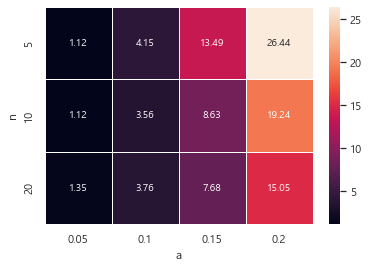

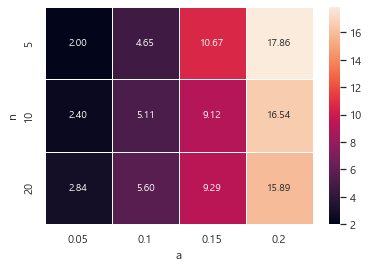

In [21]:
# 평균값, 중위수 시각화
sns.heatmap(mean_result, annot = True, fmt = ".2f", linewidth = 1)
plt.yticks([0.5, 1.5, 2.5], [5, 10, 20])
plt.xticks([0.5, 1.5, 2.5, 3.5], [0.05, 0.1, 0.15, 0.2])
plt.ylabel("n")
plt.xlabel("a")
plt.show()

sns.heatmap(median_result, annot = True, fmt = ".2f", linewidth = 1)
plt.yticks([0.5, 1.5, 2.5], [5, 10, 20])
plt.xticks([0.5, 1.5, 2.5, 3.5], [0.05, 0.1, 0.15, 0.2])
plt.ylabel("n")
plt.xlabel("a")
plt.show()

# 평균과 중위수가 모든 경우에서 양수
# a값을 크게, 즉, 지지선을 낮고 저항선을 높에 설정할수록 수익률이 큰 폭으로 좋아짐